# pySPaRTAN: a Python computational framework for linking cell-surface receptors to transcriptional regulators

## Introduction

Cell identity and function depend on complex signaling and transcriptional programs. Advances in single-cell technology have enabled the analysis of transcriptional states coupled with cell surface receptor expression. This tutorial will demonstrate the usage of our computational framework pySPaRTAN, a Python implementation of the SPaRTAN (Single-cell Proteomic and RNA-based Transcription factor Activity Network) framework. SPaRTAN models the flow of information from cell-surface receptors to transcription factors (TFs), then regulate target genes. pySPaRTAN utilizes CITE-seq data, which includes cell surface protein and gene expression, to infer TF activity.



<img src="pySPaRTAN_diagram_1.png" alt="Diagram" width="600" />

## Environment setup

Download the repository and follow the "Environment Setup" section in README.txt to install the Conda environment, JupyterLab, and Python packages listed in requirements_pyspartan.txt.

pySPaRTAN is a Python-based model. To enhance runtime performance, we converted certain computationally intensive Python functions into two Cython modules. Cython is platform-dependent, we need to build the cython objects on site.

Build two Cython objects. 

In [1]:
! python  setup.py build_ext --inplace

Compiling cythLeastR/cythLeastR.pyx because it changed.
Compiling cythKronPlus/cythKronPlus.pyx because it changed.
[1/2] Cythonizing cythKronPlus/cythKronPlus.pyx
/Users/xim33/Anaconda/anaconda3/envs/seminar2024/lib/python3.12/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/xim33/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Dr. Osmanbeyoglu/Tutorials-on-ISMB-2024/hands-on_tutorial/session-2/pySPaRTAN/cythKronPlus/cythKronPlus.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
[2/2] Cythonizing cythLeastR/cythLeastR.pyx
/Users/xim33/Anaconda/anaconda3/envs/seminar2024/lib/python3.12/site-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /Users/xim33/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Dr. Osmanbeyoglu/Tutor

If you encounter any issues while generating Cython objects, please refer to our pySPaRTAN GitHub page at https://github.com/osmanbeyoglulab/SPaRTAN/tree/main/pySPaRTAN for detailed instructions.

After successfully building the Cython objects, there are two .so files generated on a Mac/Linux machine or .pyd files on a Windows machine.

In [2]:
! ls 

build                              pySPaRTAN.py
cythKronPlus                       pySPaRTAN_diagram_1.png
cythKronPlus.cpython-312-darwin.so pySPaRTAN_diagram_2.png
cythLeastR                         pySPaRTAN_diagram_3.png
cythLeastR.cpython-312-darwin.so   pySPaRTAN_tutorial.ipynb
equation_1.png                     setup.py
equation_4.png


Use "ls" command on Mac computer; "dir" command on Windows computer

We import the python packages used in this tutorial

In [1]:
import scanpy as sc
from muon import prot as pt
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import normalize

from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from itertools import chain
from adjustText import adjust_text

from pySPaRTAN import pySPaRTAN

## Data pre-processing
### Data loading

We demonstrate the pipeline using the CITE-seq dataset of Peripheral Blood Mononuclear Cells (PBMC), which is freely available from 10X Genomics. 

We load the raw counts data saved in the .h5 file.

In [2]:
adata=sc.read_10x_h5("../data/5k_pbmc_protein_v3_nextgem_filtered_feature_bc_matrix.h5", gex_only=False)
# making the variable name unique
adata.var_names_make_unique()
adata

/Users/xim33/Anaconda/anaconda3/envs/seminar2024/lib/python3.12/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 5527 × 33570
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence'

In [3]:
set(adata.var["feature_types"])

{'Antibody Capture', 'Gene Expression'}

The ADT and RNA data are stored in the same adata object, differentiated by the feature_types variable. We will separate them into two distinct objects.

Extracting gene expression raw counts

In [4]:
RNA = adata[:, adata.var["feature_types"] == "Gene Expression"]

Extracting the ADT (protein) raw counts

In [5]:
ADT = adata[:,adata.var["feature_types"]=="Antibody Capture"].copy()

# removing the isotype control for antibody
ADT=ADT[:,[x for x in ADT.var_names if "control" not in x]]

### Quality control

We calculate QC matrix and inspect some of the features:

* the number of genes expressed in the count matrix

* the total counts per cell

* the percentage of counts in mitochondrial genes

/var/folders/p7/l3vgwn3s1vl6wg6p16kkq0l00000gr/T/ipykernel_41835/444021091.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  RNA.var['mt'] = RNA.var_names.str.startswith('MT-')


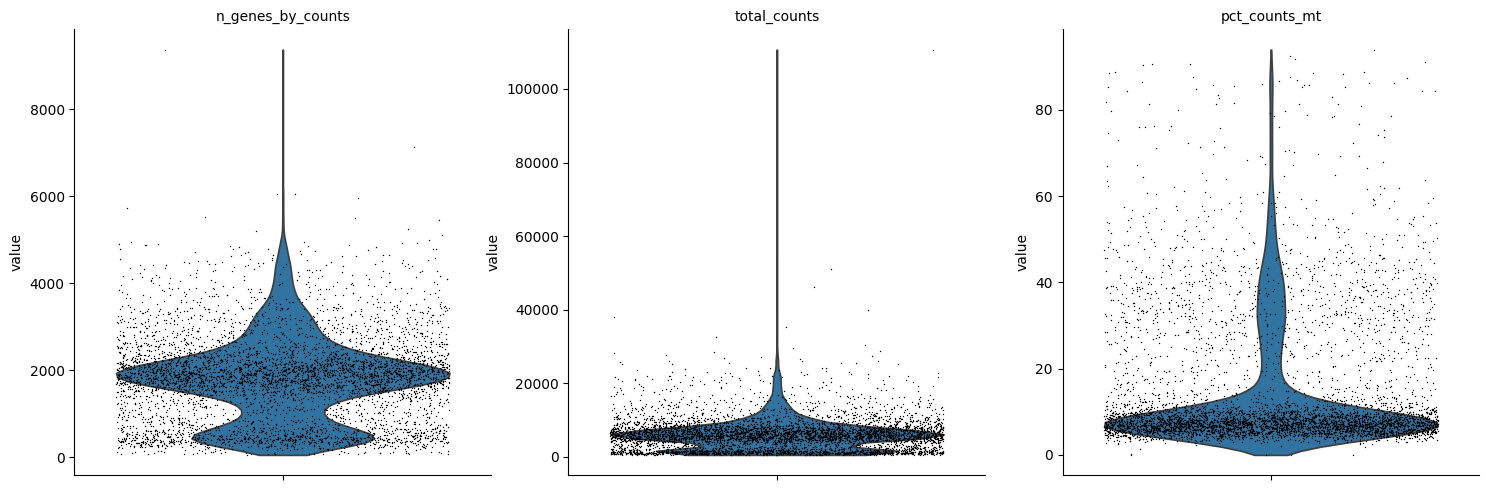

In [6]:
RNA.var['mt'] = RNA.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(RNA, qc_vars=['mt'], percent_top=None, log1p=False,inplace=True)

sc.pl.violin(
    RNA,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

Based on QC metric plots, we filter out cells with fewer than 1,000 or more than 5,000 unique gene sequences, as well as cells with more than 30% mitochondrial counts. Additionally, we exclude genes that are not present in at least 3% of cells. we also remove all mitoconondrial genes from the datset

In [7]:
sc.pp.filter_cells(RNA, min_genes=1000)
RNA=RNA[RNA.obs.query("n_genes_by_counts < 5000 and pct_counts_mt<30").index]

sc.pp.filter_genes(RNA, min_cells=0.03*RNA.n_obs)

# we also remove all mitoconondrial genes from the datset
RNA=RNA[:, RNA.var['mt']==False]

# Filter cells of ADT according to RNA
ADT = ADT[RNA.obs_names, :]

/Users/xim33/Anaconda/anaconda3/envs/seminar2024/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:275: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


### Normalization

We scale the mRNA raw count data to a sum of 1e4 and normalize it with log1p transformation. 

In [8]:
sc.pp.normalize_total(RNA, target_sum=10000)
sc.pp.log1p(RNA)

/Users/xim33/Anaconda/anaconda3/envs/seminar2024/lib/python3.12/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


For the protein, we normalize the raw counts using the center log ratio (CLR) transformation with the clr function from the Muon package.

In [9]:
pt.pp.clr(ADT)

/Users/xim33/Anaconda/anaconda3/envs/seminar2024/lib/python3.12/site-packages/muon/_prot/preproc.py:219: UserWarning: adata.X is sparse but not in CSC format. Converting to CSC.
  warn("adata.X is sparse but not in CSC format. Converting to CSC.")


## Cell type annotation

The pySPaRTAN model performs best when applied to data from different cell types separately. Next, we will prepare to annotate cell types.

Before further processing, we save the log-normalized mRNA data, which will be used as input for pySPaRTAN.

In [10]:
RNA.layers['log1p'] = RNA.X.copy()

### Feature selection
We subset features that only include highly variable genes which are highly expressed in some cells, and lowly expressed in others. Focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

We identify highly variable features and return top 5000 genes

In [11]:
sc.pp.highly_variable_genes(RNA, n_top_genes=5000)

### Dimensionality Reduction
Before reducing the dimensionality of the data, we apply a linear transformation that scales the data such that the mean expression across cells is 0 and the variance across cells is 1

In [12]:
sc.pp.scale(RNA)

We apply principal component analysis with default setting (return top 50 principal components)

In [13]:
sc.tl.pca(RNA)

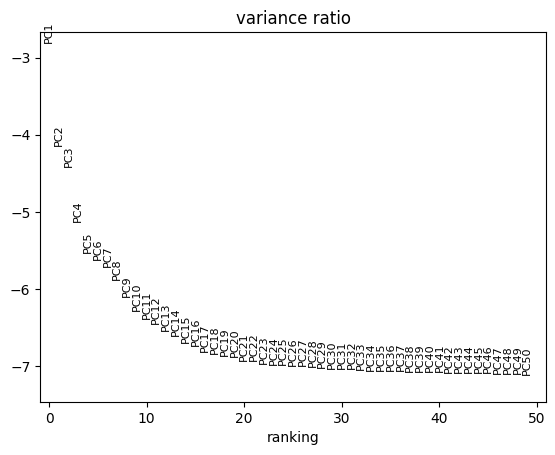

In [14]:
sc.pl.pca_variance_ratio(RNA, n_pcs=50, log=True)

### Clustering

First construct a KNN graph based on the euclidean distance in PCA space

In [15]:
sc.pp.neighbors(RNA, n_neighbors=20, n_pcs=20)

Next cluster cells using  Leiden algorithm which is considered as an improved version of the Louvain algorithm

In [18]:
sc.tl.leiden(RNA, flavor="igraph", n_iterations=2, resolution=1.2)

Then we embed the neighborhood graph into a two-dimensional space and visualize it using UMAP

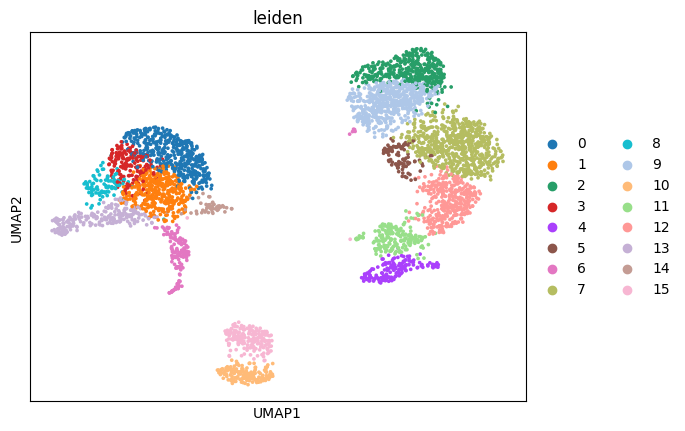

In [19]:
sc.tl.umap(RNA)
sc.pl.umap(RNA, color=["leiden"])

### Annotation

We annotated the cell types based on the listed marker genes and proteins below.

In [20]:
display(HTML('<header class="u-mb-16"><h4 class="c-article-satellite-title u-h1" id="table-2-title">Marker genes used to assign cell types to clusters</h4></header><div class="c-article-table-container"><div class="c-article-table-border c-table-scroll-wrapper"><div class="c-table-scroll-wrapper__content" data-component-scroll-wrapper=""><table class="data last-table"><thead class="c-article-table-head"><tr><th class="u-text-left "><p>Cell type</p></th><th class="u-text-left "><p>Marker genes</p></th><th class="u-text-left "><p>Marker proteins</p></th></tr></thead><tbody><tr><td class="u-text-left "><p>CD8+</p></td><td class="u-text-left "><p><i>CD8A</i>, <i>CD8B</i>, <i>FCER1G</i></p></td><td class="u-text-left "><p>CD8a, CD4</p></td></tr><tr><td class="u-text-left "><p>Naive CD4+ T</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>CCR7</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RA, CD4</p></td></tr><tr><td class="u-text-left "><p>Memory CD4+</p></td><td class="u-text-left "><p><i>IL7R</i>, <i>S100A4</i>, <i>CD3E</i></p></td><td class="u-text-left "><p>CD45RO, CD4</p></td></tr><tr><td class="u-text-left "><p>NK</p></td><td class="u-text-left "><p><i>GNLY</i>, <i>NKG7</i></p></td><td class="u-text-left "><p>CD56</p></td></tr><tr><td class="u-text-left "><p>DC</p></td><td class="u-text-left "><p><i>FCER1A</i>, <i>CST3</i></p></td><td class="u-text-left "> </td></tr><tr><td class="u-text-left "><p>CD14+ Mono</p></td><td class="u-text-left "><p><i>CD14</i>, <i>LYZ</i></p></td><td class="u-text-left "><p>CD14</p></td></tr><tr><td class="u-text-left "><p>FCGR3A+/CD16+ Mono</p></td><td class="u-text-left "><p><i>FCGR3A</i>, <i>MS4A7</i></p></td><td class="u-text-left "><p>CD16</p></td></tr><tr><td class="u-text-left "><p>B</p></td><td class="u-text-left "><p><i>MS4A1</i></p></td><td class="u-text-left "><p>CD20, CD19</p></td></tr></tbody></table></div></div></div><div class="u-text-right"></div>'))

Cell type,Marker genes,Marker proteins
CD8+,"CD8A, CD8B, FCER1G","CD8a, CD4"
Naive CD4+ T,"IL7R, CCR7, CD3E","CD45RA, CD4"
Memory CD4+,"IL7R, S100A4, CD3E","CD45RO, CD4"
NK,"GNLY, NKG7",CD56
DC,"FCER1A, CST3",
CD14+ Mono,"CD14, LYZ",CD14
FCGR3A+/CD16+ Mono,"FCGR3A, MS4A7",CD16
B,MS4A1,"CD20, CD19"


The process involved multiple iterations of subclustering and re-annotation, making it difficult to show the entire process. We loaded the saved cell type annotation file.

In [21]:
df_ct = pd.read_csv("../data/cell_types_PBMC.csv", index_col=0)

/var/folders/p7/l3vgwn3s1vl6wg6p16kkq0l00000gr/T/ipykernel_40864/3572330135.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  RNA.obs["cell_types"] = df_ct.loc[RNA.obs_names]


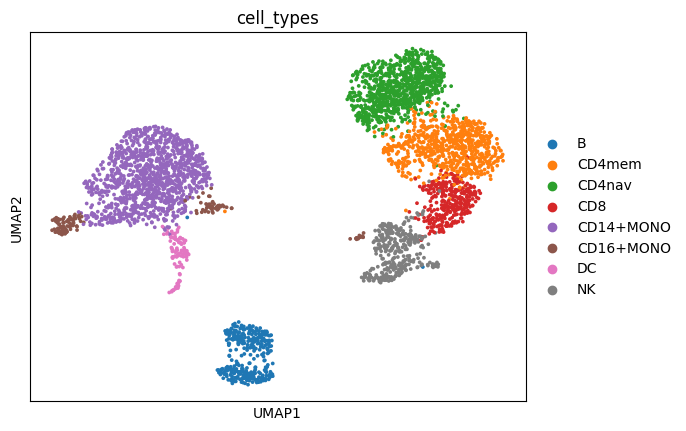

In [22]:
# Annotating cell type on UMAP
RNA=RNA[np.intersect1d(RNA.obs_names, df_ct.index)] 
RNA.obs["cell_types"] = df_ct.loc[RNA.obs_names]
sc.pl.umap(RNA, color=["cell_types"])

Checking the number of cells for each cell type.

In [23]:
RNA.obs["cell_types"].value_counts()

cell_types
CD14+MONO    1203
CD4nav        910
CD4mem        716
NK            353
B             332
CD8           319
CD16+MONO     139
DC             99
Name: count, dtype: int64

## pySPaRTAN execution
### Reviewing pySPaRTAN model

SPaRTAN is structured as a bilinear regression model. The inputs consist of: D: gene-TF matrix, P: a matrix of cell x protein, representing normalized protein expression data derived from our processed CITE-seq data, and Y: a gene x cell matrix, representing normalized gene expression data from the same CITE-seq dataset. The model learns the interaction matrix W between cell surface proteins and transcription factors that best predicts the target gene expression.

<img src="pySPaRTAN_diagram_2.png" alt="Diagram" width="600" />

<img src="equation_1.png" alt="Diagram" width="120" />

There are three inputs for the package: D, P Y

D: gene-tf matrix.

P: cell x ADT matrix. 

Y: gene x cell matrix, 


We convert this bilinear equation into a linear regression and apply approximations to expedite its solution. For method details, please refer to https://academic.oup.com/nar/article/49/17/9633/6368058 .

After training the model, we obtain the learned TF and protein interaction matrix W. From matrix W we can 
1. predict TF activities from the cell surface protein expression profile
   

2. protein activities from the cellular mRNA expression data and the TF-target gene matrix



<img src="pySPaRTAN_diagram_3.png" alt="Diagram" width="600" />

### Generating pySPaRTAN input data

Loading gene-TF matrix

In [24]:
# We load the curated gene-TF dataframe for PBMC dataset
geneTF = pd.read_csv("../data/D_pbmc.csv", index_col=0)
geneTF.shape

(2643, 255)

Note: SPaRTAN model requires log normalized RNA expression as input. Current RNA.X has been scaled during cell type annotation, we need to load the normalized data back to RNA.X

In [25]:
RNA.X = RNA.layers['log1p']
# Aligning the genes in RNA with those in geneTF matrix
RNA = RNA[:, geneTF.index]

As we mentioned previously, the pySPaRTAN model performs best when applied separately to data from different cell types. We will extract RNA and ADT data for each cell type. 
Note: here we convert the AnnData object to Pandas dataframe

In [26]:
RNAs={}; ADTs={}
for celltype in set(df_ct["cell_types"]):
    index_type = df_ct.index[df_ct["cell_types"]==celltype]
    RNA_type = RNA[RNA.obs_names.isin(index_type)].to_df()
    ADT_type = ADT[ADT.obs_names.isin(index_type)].to_df()

    RNAs[celltype] = RNA_type
    ADTs[celltype] = ADT_type

RNAs.keys()

dict_keys(['CD16+MONO', 'CD14+MONO', 'DC', 'B', 'CD4mem', 'CD4nav', 'NK', 'CD8'])

### Training cell-type specific pySPaRTAN model
After preparing the input for pySPaRTAN, we are ready to run the model. We will use the CD8 T cell to demonstrate the procedure.

In [27]:
ct = "CD8"
D = geneTF.copy()
P = ADTs[ct].copy()
Y = RNAs[ct].copy()
# D, P, Y are Pandas dataframes

In [28]:
D.shape, P.shape, Y.shape

((2643, 255), (319, 29), (319, 2643))

Before training the model, we recommend normalizing D, P, and Y using l2 normalization. P and Y are normalized within cells.

In [29]:
D = pd.DataFrame(normalize(D.values, axis=0), index=D.index, columns=D.columns)
P = pd.DataFrame(normalize(P.values, axis=1), index=P.index, columns=P.columns)
Y = pd.DataFrame(normalize(Y.values, axis=1), index=Y.index, columns=Y.columns)

P and Y are normalized CD8 T cell protein and RNA expression where each row represent a cell and each column represent a protein or a gene.  Different cell type will have different dimension size of P and Y matrix. While gene-TF matrix has the fixed size for all cell types. 

Note: The P matrix is corresponding to the Pt in above diagram figure

In order to accurately evaluate the model’s performance, we train the model using 80% of cells. The remaining 20% will be reserved for testing .

In [30]:
P_train, P_test, Y_train, Y_test = train_test_split(
    P, Y, test_size=0.2, random_state=0)

pySPaRTAN is a regularized bilinear model that incorporates three hyperparameters: lambda, rsL2, and spectrum. Lambda and rsL2 control the trade-off between L1 and L2 regularization. Spectrum controls the truncation of the P matrix by singular value decomposition. For example, setting spectrum=0.7 specifies the number of singular vectors capturing 70% of the full spectrum. For clear meaning of those hyperparameters, please refer to our paper https://academic.oup.com/nar/article/49/17/9633/6368058

To tune these hyperparamters, We employ cross-validation and grid search to determine the optimal values of lambda (ranging from 1e-5 to 10) and rsL2 (ranging from 0 to 1). The spectrum parameter requires less tuning; hence, we fix it at 0.7.

We define the list of lambda and rsL2 and fold of cross validation as follows:

In [31]:
lamdas = [0.001, 0.01, 0.1]
rsL2s = [0.001, 0.01]
spectrums = [0.7]

fold = 5

First we need to initiate the model with those parameters

In [32]:
model = pySPaRTAN(lambdas = lamdas, rsL2s = rsL2s, spectrums=spectrums, n_fold=fold)


Then train the model by passing the D, P, Y datasets

In [ ]:
model.fit(D=D, P=P, Y=Y)

cross validating  spectrum=0.7, lambda=0.001, rsL2=0.001
cross validating  spectrum=0.7, lambda=0.001, rsL2=0.01
cross validating  spectrum=0.7, lambda=0.01, rsL2=0.001
cross validating  spectrum=0.7, lambda=0.01, rsL2=0.01


After training the model on the training dataset, we evaluate its ability to predict gene expression based on protein expression using the testing dataset

In [ ]:
score = model.get_pred_score(P_test, Y_test)
score

This score is the correlation between predicted gene expression and observed gene expression, serving as the evaluation metric for prediction performance.

Now, we obtain the inferred TF activity for all CD8 T cells based on the its protein expression.

In [ ]:
tf =model.get_projTF(P)
tf

## Analyzing results

Here we explore the associations between inferred TF activity and surface protein expression at a single-cell level.

We first compute Pearson correlation coefficients between inferred TF activity and surface protein expression for each TF-protein pair within the cell-type

In [ ]:
tf_protein = model.get_tf_protein_cor()
tf_protein

Trim the end of protein names

In [ ]:
tf_protein.columns = tf_protein.columns.str[:-10]
tf_protein.columns

We select the TFs and proteins with high absolute correlation values 

In [ ]:
proteins_to_plot = tf_protein.columns[abs(tf_protein).max(axis=0) > 0.7]
tfs_to_plot = tf_protein.index[abs(tf_protein).max(axis=1) > 0.85]
tf_protein_plot = tf_protein.loc[tfs_to_plot, proteins_to_plot]

Then we plot heatmap of the selected protein-TF correlation

In [ ]:
sns.clustermap(
    tf_protein_plot,
    cmap="bwr",vmin=-1, vmax=1
).fig.suptitle(ct + " T cell protein-TF correlation", y=1.05,fontsize=20)

Finally, we plot the TF correlation with specific protein, highlight the TFs with highest and lowest correlations.

Defining the plot function

In [ ]:
def line_plot(pcc,prot, N, ax):
    
    pcc_prot = pcc.loc[:, prot].sort_values()

    labels = pcc_prot.index

    x= range(1,len(pcc_prot)+1)
    y=pcc_prot

    ax.scatter(x, y, s=8)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    texts = [ax.text(x[i], y[i], '%s' %labels[i], ha='center', va='center', fontsize=10) for i in range_c]
    adjust_text(texts, arrowprops=dict(arrowstyle="-", color='r'), ax=ax, min_arrow_len=0, time_lim=0.1)

    ax.set_xlabel("TF ranking", fontsize=15)
    ax.set_ylabel(f"Corr between {prot} exp and TF activity", fontsize=15)
    ax.set_title(prot)

    range_c = chain(range(0,N), range(len(x)-N, len(x)))
    TF_labels = [labels[i] for i in range_c]
    return(TF_labels)


Plotting lineplot

In [ ]:
plt.rcParams['figure.figsize'] = [14, 7]
fig, ax = plt.subplots(1,2)
prot = "CD127"
line_plot(tf_protein, prot, 8, ax[0])
prot = "TIGIT"
line_plot(tf_protein, prot, 8, ax[1])

fig.show()
